# ConsPortfolioModel Documentation

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/econ-ark/DemARK/master?filepath=notebooks%2FConsPortfolioModelDoc.ipynb)

In [1]:
# Setup stuff

import HARK.ConsumptionSaving.ConsPortfolioModel as cpm
import HARK.ConsumptionSaving.ConsumerParameters as param
import copy
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from HARK.ConsumptionSaving.ConsPortfolioModel import PortfolioSolution

We implement three different ways to allow portfolio choice.

The agent can choose 
  * any portfolio share ('continuous choice')
  * only a specified set of portfolio shares ('discrete choice')
  * With probability 1 (agent always gets to choose)
  * With probability 0 < p < 1 (stochastic chance to choose)
        
We allow two choices for the description of the 
distribution of the stochastic variable:
  1. A generic discrete probability distribution
     * Nodes and their probabilities are specified
  2. A true lognormal distribution
     * The mean return and the standard deviation are specified
        
In the discrete portfolio shares case, the user also must
input a function that *draws* from the distribution in drawRiskyFunc

Other assumptions: 
  * distributions are time constant
  * probability of being allowed to reoptimize is time constant
     * If p < 1, you must specify the PortfolioSet discretely
      

In [2]:
# Set up the model
# Parameters from Mehra and Prescott (1985):
Avg = 1.08 # equity premium 
Std = 0.20 # standard deviation of rate-of-return shocks 

RiskyDstnFunc = cpm.RiskyDstnFactory(RiskyAvg=Avg, RiskyStd=Std)       # Generates nodes for integration
RiskyDrawFunc = cpm.LogNormalRiskyDstnDraw(RiskyAvg=Avg, RiskyStd=Std) # Generates draws from a lognormal distribution

init_portfolio = copy.copy(param.init_idiosyncratic_shocks) # Default parameter values for inf horiz model
init_portfolio['approxRiskyDstn'] = RiskyDstnFunc
init_portfolio['drawRiskyFunc']   = RiskyDrawFunc
init_portfolio['RiskyCount']      = 2   # Number of points in the approximation; 2 points is minimum
init_portfolio['RiskyShareCount'] = 25  # How many discrete points to allow in the share approximation
init_portfolio['Rfree']           = 1.0 # Riskfree return factor is 1 (interest rate is zero)
init_portfolio['CRRA']            = 6.0 # Relative risk aversion

# Uninteresting technical parameters:
init_portfolio['aXtraMax']        = 100 
init_portfolio['aXtraCount']      = 50
init_portfolio['BoroCnstArt']     = 0.0 # important for theoretical reasons
# init_portfolio['vFuncBool'] = True # We do not need value function for purposes here

init_portfolio['DiscFac'] = 0.90
# Create portfolio choice consumer type
pcct = cpm.PortfolioConsumerType(**init_portfolio)

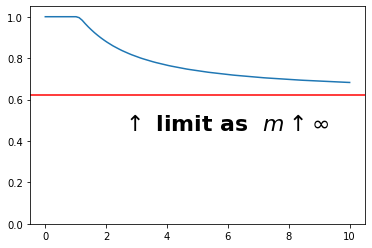

In [3]:
# Solve the model under the given parameters

pcct.solve()
aMin = 0   # Minimum ratio of assets to income to plot
aMax = 10  # Maximum ratio of assets to income to plot
aPts = 100 # Number of points to plot 

# Campbell-Viceira (2002) approximation to optimal portfolio share in Merton-Samuelson (1969) model
pcct.MertSamCampVicShare = pcct.RiskyShareLimitFunc(RiskyDstnFunc(init_portfolio['RiskyCount']))
eevalgrid = np.linspace(0,aMax,aPts) # range of values of assets for the plot
plt.plot(eevalgrid, pcct.solution[0].RiskyShareFunc[0][0](eevalgrid))
plt.axhline(pcct.MertSamCampVicShare, c='r') # The Campbell-Viceira approximation
plt.ylim(0,1.05)
plt.text((aMax-aMin)/4,0.45,r'$\uparrow$ limit as  $m \uparrow \infty$',fontsize = 22,fontweight='bold')
plt.show()

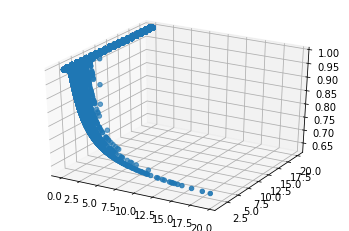

In [4]:
# Simulate 20 years of behavior for a set of consumers 
SimPer = 20

pcct.track_vars = ['aNrmNow', 't_age', 'RiskyShareNow']
pcct.T_sim = SimPer
pcct.initializeSim()
pcct.simulate()
pcct.RiskyShareNow_hist

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim(pcct.MertSamCampVicShare,1.0)
ax.scatter(pcct.aNrmNow_hist, pcct.t_age_hist, pcct.RiskyShareNow_hist)
plt.show()

# The consumers are very impatient and so even if they start rich they end up as buffer stock savers
# But with all of their buffer stock savings in the stock market

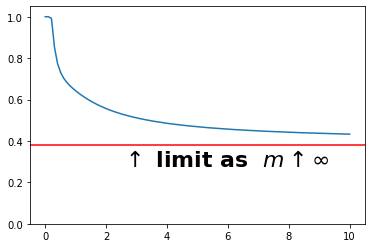

In [5]:
# Solve the specialized / simple version for which there is a good approximation
# This is the version for which Campbell and Viceira provide an approximate formula
# assuming log normally distributed shocks

init_lognormportfolio = copy.deepcopy(init_portfolio) # Use same parameter values
init_lognormportfolio['RiskyAvg']   = Avg
init_lognormportfolio['RiskyStd']   = Std
init_lognormportfolio['RiskyCount'] = 11 # Eleven is enough points to do justice to the distribution
lnpcct = cpm.LogNormalPortfolioConsumerType(**init_lognormportfolio)

lnpcct.solve()
lnpcct.MertSamCampVicShare = lnpcct.RiskyShareLimitFunc(RiskyDstnFunc(init_portfolio['RiskyCount']))

plt.plot(eevalgrid, lnpcct.solution[0].RiskyShareFunc[0][0](eevalgrid))
plt.axhline(lnpcct.MertSamCampVicShare, c='r')
plt.ylim(0,1.05)
plt.text((aMax-aMin)/4,lnpcct.MertSamCampVicShare-0.1,r'$\uparrow$ limit as  $m \uparrow \infty$',fontsize = 22,fontweight='bold')
plt.show()

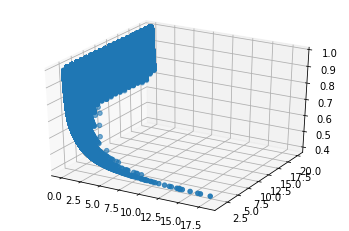

In [6]:
# Again simulate a few periods 
lnpcct.track_vars = ['aNrmNow', 't_age', 'RiskyShareNow']
lnpcct.T_sim = SimPer
lnpcct.initializeSim()
lnpcct.simulate()
lnpcct.RiskyShareNow_hist

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lnpcct.aNrmNow_hist, lnpcct.t_age_hist, lnpcct.RiskyShareNow_hist)
ax.set_zlim(lnpcct.MertSamCampVicShare,1.0)
plt.show()

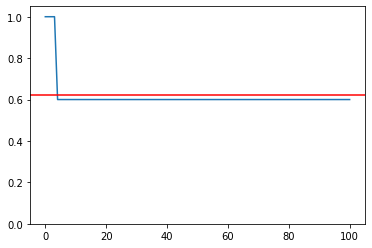

In [7]:
# Version where only discrete values of portfolio share of risky assets are allowed

init_portfolio_prb = copy.deepcopy(init_portfolio)

init_portfolio_prb['AdjustPrb'] = 1.0
init_portfolio_prb['PortfolioDomain'] = cpm.DiscreteDomain([0.0, 0.5, 0.6, 1.0])
pcct_prb = cpm.PortfolioConsumerType(**init_portfolio_prb)
pcct_prb.solve()

eevalgrid = np.linspace(0,100,100)
plt.plot(eevalgrid, pcct_prb.solution[0].RiskyShareFunc[0][0](eevalgrid))
plt.axhline(pcct_prb.RiskyShareLimitFunc(RiskyDstnFunc(init_portfolio['RiskyCount'])), c='r')
plt.ylim(0,1.05)
plt.show()

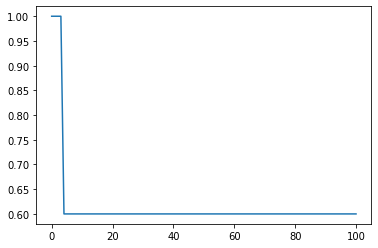

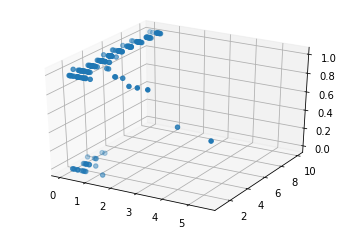

In [8]:
# Version where you can choose your portfolio share only with some 0 < p < 1

init_portfolio_prb = copy.deepcopy(init_portfolio)

init_portfolio_prb['AdjustPrb'] = 0.5
init_portfolio_prb['PortfolioDomain'] = cpm.DiscreteDomain([0.0, 0.6, 1.0])
pcct_prb = cpm.PortfolioConsumerType(**init_portfolio_prb)

pcct_prb.solve()

plt.plot(eevalgrid, pcct_prb.solution[0].RiskyShareFunc[0][0](eevalgrid))
plt.show()

pcct_prb.track_vars = ['aNrmNow', 't_age', 'RiskyShareNow', 'CantAdjust']
pcct_prb.T_sim = 10
pcct_prb.AgentCount = 30
pcct_prb.initializeSim()
pcct_prb.simulate()
pcct_prb.RiskyShareNow_hist

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pcct_prb.aNrmNow_hist, pcct_prb.t_age_hist, pcct_prb.RiskyShareNow_hist)
plt.show()